In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load MERRA2 indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_Submission_30Apr2020'



In [4]:

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size

##Find .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'



In [5]:
#For MERRA, decode_cf needs to be set to True for proper concatenation on T axis
MERRA_DATA = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(MERRA_DATA)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...


In [6]:
#getting variables in right units 
slp_tmon_merra = MERRA_DATA.msl/100 #hPa
v10_tmon_merra = MERRA_DATA.v10 #in m/s at 10m
u10_tmon_merra = MERRA_DATA.u10 #in m/s at 10m
t2m_tmon_merra = MERRA_DATA.t2m-273.15 #in C
tp_tmon_merra  = MERRA_DATA.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = MERRA_DATA.ci #in [0-1] fraction of sea ice
sst_tmon_merra = MERRA_DATA.sst #SST in C -- taken care of when making the xarray/.nc file


In [7]:
sst_tmon_merra

<xarray.DataArray 'sst' (time: 456, lat: 121, lon: 240)>
[13242240 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [8]:
#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_merra_df.head(n=5)
Rel_CP_djf_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_merra.head(n=5)
Rel_CP_mam_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_merra.head(n=5)
Rel_CP_jja_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_merra.head(n=5)
Rel_CP_son_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_merra.head(n=5)
Rel_CP_ann_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_merra.head(n=5))

                vals  lats   lons  sectormean  indice
time                                                 
1980-01-01 -4.454987 -73.5  207.0  990.259126       0
1981-01-01 -4.978481 -72.0  214.5  987.240688       1
1982-01-01 -5.265890 -73.5  205.5  986.160849       2
1983-01-01 -5.715246 -70.5  253.5  985.146704       3
1984-01-01 -5.524716 -75.0  207.0  986.935604       4


In [9]:
#Adding Abs CP column to Rel_CP dataframe
Rel_CP_djf_mean_indices_raw_merra['abs_vals'] = (Rel_CP_djf_mean_indices_raw_merra.vals + Rel_CP_djf_mean_indices_raw_merra.sectormean)
Rel_CP_mam_mean_indices_raw_merra['abs_vals'] = (Rel_CP_mam_mean_indices_raw_merra.vals + Rel_CP_mam_mean_indices_raw_merra.sectormean)
Rel_CP_jja_mean_indices_raw_merra['abs_vals'] = (Rel_CP_jja_mean_indices_raw_merra.vals + Rel_CP_jja_mean_indices_raw_merra.sectormean)
Rel_CP_son_mean_indices_raw_merra['abs_vals'] = (Rel_CP_son_mean_indices_raw_merra.vals + Rel_CP_son_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra['abs_vals'] = (Rel_CP_ann_mean_indices_raw_merra.vals + Rel_CP_ann_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1980-01-01,-4.454987,-73.5,207.0,990.259126,0,985.804138
1981-01-01,-4.978481,-72.0,214.5,987.240688,1,982.262207
1982-01-01,-5.265890,-73.5,205.5,986.160849,2,980.894958
1983-01-01,-5.715246,-70.5,253.5,985.146704,3,979.431458
1984-01-01,-5.524716,-75.0,207.0,986.935604,4,981.410889
1985-01-01,-6.377041,-73.5,214.5,984.389492,5,978.012451
1986-01-01,-5.511735,-75.0,207.0,988.455095,6,982.943359
1987-01-01,-4.600063,-73.5,202.5,986.560756,7,981.960693
1988-01-01,-5.634635,-72.0,210.0,984.990348,8,979.355713


## Mapping absolute and relative SLP

In [10]:
asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -80 #need to go a bit passed 60S to get a full grid point; flip hi lo for icesm
asl_ylo_slice = -59.6 #

shem_xhi_slice = 360 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -90 #
shem_ylo_slice = -15 #

In [11]:
#SLP land values are masked Still a dask array
SLP_abs_tmon_merra = slp_tmon_merra.sel(lon=slice(shem_xlo_slice, shem_xhi_slice), lat=slice(shem_ylo_slice, shem_yhi_slice))
SLP_abs_tmon_merra = SLP_abs_tmon_merra.where(~np.isnan(sst_tmon_merra))
# SLP_abs_tmon_merra[0].plot()

#making the chunksize 1 seems to speed up the finding of mins code below
SLP_abs_tmon_merra = SLP_abs_tmon_merra.chunk({'time':1})
SLP_abs_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 51, lon: 240)>
dask.array<shape=(456, 51, 240), dtype=float32, chunksize=(1, 51, 240)>
Coordinates:
  * lat      (lat) float64 -15.0 -16.5 -18.0 -19.5 ... -85.5 -87.0 -88.5 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

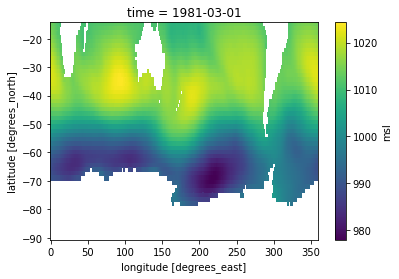

In [12]:
SLP_abs_tmon_merra[14,:,:].plot()

In [13]:
lat_vals = MERRA_DATA.coords['lat']
lat_vals = lat_vals.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values
lat_vals

array([-15. , -16.5, -18. , -19.5, -21. , -22.5, -24. , -25.5, -27. ,
       -28.5, -30. , -31.5, -33. , -34.5, -36. , -37.5, -39. , -40.5,
       -42. , -43.5, -45. , -46.5, -48. , -49.5, -51. , -52.5, -54. ,
       -55.5, -57. , -58.5, -60. , -61.5, -63. , -64.5, -66. , -67.5,
       -69. , -70.5, -72. , -73.5, -75. , -76.5, -78. , -79.5, -81. ,
       -82.5, -84. , -85.5, -87. , -88.5, -90. ])

In [14]:
rad = round(4.0*np.arctan(1.0)/180.0,5)  #equals pi/180, rounding to conserve space
wlat = np.cos(lat_vals*rad)  #cos of lat
wlat

array([9.65938608e-01, 9.58835163e-01, 9.51074829e-01, 9.42662921e-01,
       9.33605203e-01, 9.23907880e-01, 9.13577595e-01, 9.02621427e-01,
       8.91046880e-01, 8.78861884e-01, 8.66074787e-01, 8.52694350e-01,
       8.38729740e-01, 8.24190522e-01, 8.09086659e-01, 7.93428498e-01,
       7.77226765e-01, 7.60492561e-01, 7.43237350e-01, 7.25472953e-01,
       7.07211541e-01, 6.88465624e-01, 6.69248045e-01, 6.49571970e-01,
       6.29450879e-01, 6.08898557e-01, 5.87929083e-01, 5.66556824e-01,
       5.44796422e-01, 5.22662784e-01, 5.00171075e-01, 4.77336702e-01,
       4.54175310e-01, 4.30702767e-01, 4.06935153e-01, 3.82888751e-01,
       3.58580035e-01, 3.34025659e-01, 3.09242445e-01, 2.84247371e-01,
       2.59057562e-01, 2.33690275e-01, 2.08162888e-01, 1.82492891e-01,
       1.56697870e-01, 1.30795496e-01, 1.04803516e-01, 7.87397353e-02,
       5.26220108e-02, 2.64682354e-02, 2.96326791e-04])

In [15]:
ones_3d = np.ones(slp_tmon_merra.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).shape)
wlat_3d = ones_3d * wlat[np.newaxis, :, np.newaxis]
wlat_3d.shape

(456, 51, 240)

To weight, take zonal mean (brackets) of the product of the variable for the region (170E-298E) and the weight (cosine of lat), then sum across the latidinal band (80S-60S).  Divide this number by zonal mean (brackets) of the weights for the region (170E-298E) and sum latidinally (80S-60S)<br>


$$
\frac {\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) *  VAR \rangle}{\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) \rangle}
$$

In [16]:
numerator = SLP_abs_tmon_merra * wlat_3d
numerator_region = numerator.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#print (numerator_region.values, numerator_region.shape)

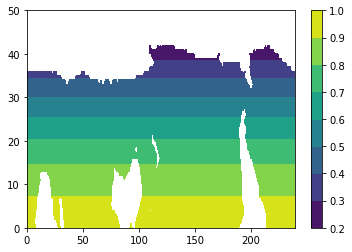

In [17]:
#turn the lat-weights into dask array for use in slicing next
da_wlat_3d = numerator / slp_tmon_merra
da_wlat_3d
plt.contourf(da_wlat_3d[0])
plt.colorbar()
plt.show()

In [18]:
denominator_region = da_wlat_3d.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#denominator_region.values

In [19]:
ASL_sectormean_tmon_merra = (numerator_region/denominator_region)
#ASL_sectormean_tmon_merra.values

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


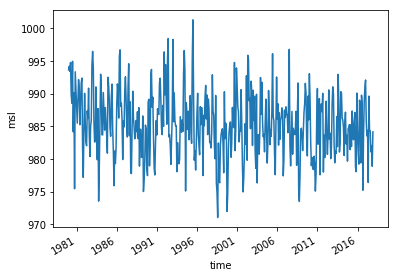

In [20]:
ASL_sectormean_tmon_merra.plot() #Verified with Hosking published data: C:\Users\Paul\Desktop\Tabor\Revisit_Monthly_ASL_indices_in_ERA_compared_to_Hosking_Published_Data.xlsx
# ASL_sectormean_tmon_merra.shape

In [21]:
#time series for the Abs CP Min vs Abs SLP sector mean and below that the Rel CP Min timeseries

In [22]:
#Abs CP Min
ASL_sectormin_tmon_merra = SLP_abs_tmon_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat'])
#ASL_sectormin_tmon_merra.plot()
#ASL_sectormin_tmon_merra.shape

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


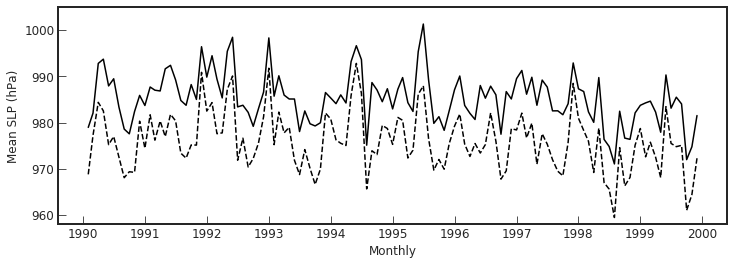

In [23]:
#Based on Hosking et al 2013, Fig. 2a
#mean slp of ASL sector (solid) and actual abs CP (dash)

x = MERRA_DATA.coords['time'].values
y_asl_sector_mean_merra = ASL_sectormean_tmon_merra.values
y_asl_abs_cp_merra = ASL_sectormin_tmon_merra.values

sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


fig, ax1 = plt.subplots()

ax1.set_xlabel('Monthly')
ax1.set_ylabel('Mean SLP (hPa)')
#ax1.set_xlim(132,253)
#ax1.xaxis.set(ticks=np.arange(132, 253, 12),
#             ticklabels=('0013','0014','0015','0016','0017','0018','0019','0020','0021','0022','0023'))
ax1.set_ylim(958,1005)
ax1.yaxis.set_ticks(np.arange(960, 1010, 10))
ax1.plot(x[121:240], y_asl_sector_mean_merra[121:240], color='k',linewidth=1.5)
ax1.plot(x[121:240], y_asl_abs_cp_merra[121:240], color='k',ls='--',linewidth=1.5)

plt.show()

In [24]:
#correlation of ABSL actual CP and area-averaged MSLP in ASL region 0013-0023
#need to detrend these time series before comparing to one-another and to SAM index nino3.4 see page 4
fff = pearsonr(ASL_sectormean_tmon_merra.values,ASL_sectormin_tmon_merra.values)
print(fff)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.8886371916296509, 8.316352320952106e-156)


In [25]:
#Every month relative CP data for climatology time series

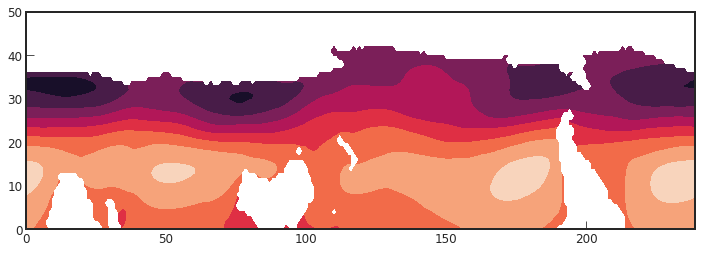

In [26]:
plt.contourf(SLP_abs_tmon_merra[0])

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


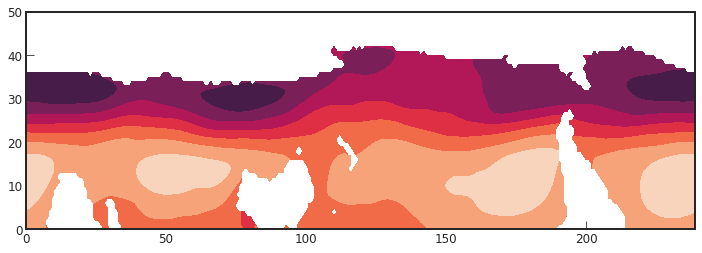

In [27]:
#RELATIVE SLP wrt ASL MEAN for each month
ASL_sector_relative_tmon_merra = SLP_abs_tmon_merra - ASL_sectormean_tmon_merra
ASL_sector_relative_tmon_merra.shape
plt.contourf(ASL_sector_relative_tmon_merra[0])

In [28]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

In [29]:
monthly_Rel_CP_location_lists = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
    current = []
    monthly_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        #print('In NW Region', t, t%12)
        #print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            #print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            #print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                #print(all_loc_mins[idx[0]][idx[0]].coords['lon'].values)
                #print(all_loc_mins[idx[0]][idx[0]].coords['lat'].values)
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
##print(monthly_Rel_CP_location_lists)


#         #print('In NW Region', t, t%12)
#         #print(min_rel_cp)
#                     #print('Empty list of arrays for t=', t)
#             #print(yy)
#             #print(idx)
#             #print(uuu)
#             #print(uuu.values)
#             #print(all_loc_mins)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In [30]:
len(monthly_Rel_CP_location_lists)

456

In [31]:
# monthly_Rel_CP_location_lists #now just one for each time step

In [32]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack

monthly_Rel_CP_location_lists_vals = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_vals.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_vals)

# monthly_Rel_CP_location_lists_times = []
# for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
#    current = []
#    monthly_Rel_CP_location_lists_times.append(current)
#    pp = monthly_Rel_CP_location_lists[t][0].coords['time'].values
#    current.append(pp)
# #print(monthly_Rel_CP_location_lists_times)

monthly_Rel_CP_location_lists_lats = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lats.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lats)

monthly_Rel_CP_location_lists_lons = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lons.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lons)

monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra = np.column_stack((monthly_Rel_CP_location_lists_vals, monthly_Rel_CP_location_lists_lats, monthly_Rel_CP_location_lists_lons))
monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra.shape

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(456, 3)

In [33]:
pd.to_datetime(slp_tmon_merra.coords['time'].values)

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', length=456, freq=None)

In [34]:
#Putting the Relative CP location information into a Pandas Dataframe
monthly_Rel_CP_location_info_merra_df = pd.DataFrame({
                    'time'         : pd.to_datetime(slp_tmon_merra.coords['time'].values),
                    'month_indice' : np.tile(np.arange(0,12,1), int(len(slp_tmon_merra.coords['time'])/12)),
                    'vals'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,0],
                    'lats'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,1],
                    'lons'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,2],
                   })
# monthly_Rel_CP_location_info_merra_df

#Make time the index column so that we can use resample for seasonal means
monthly_Rel_CP_location_info_merra_df.time = pd.to_datetime(slp_tmon_merra.coords['time'].values)
monthly_Rel_CP_location_info_merra_df.set_index('time', inplace=True)
monthly_Rel_CP_location_info_merra_df.head(n=5)
#monthly_Rel_CP_location_info_merra_df.to_csv('Monthly_ERA_Rel_CP_Loc.csv')

#Verified with Hosking published data: C:\Users\Paul\Desktop\Tabor\Revisit_Monthly_ASL_indices_in_ERA_compared_to_Hosking_Published_Data.xlsx
#Some differences in RelCP and Lon Lat occur due to how I "reselected" ASL CP... I think my method is more precise actually
#But, nearly identical sectormean vlaues to hosking

,month_indice,vals,lats,lons
time,,,,
1980-01-01,0,-5.095507,-64.5,286.5
1980-02-01,1,-5.868897,-63.0,283.5
1980-03-01,2,-6.919626,-72.0,283.5
1980-04-01,3,-7.615094,-67.5,207.0
1980-05-01,4,-7.202291,-69.0,198.0


### Absolute Seasonal data and means:

In [35]:
SLP_abs_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 51, lon: 240)>
dask.array<shape=(456, 51, 240), dtype=float32, chunksize=(1, 51, 240)>
Coordinates:
  * lat      (lat) float64 -15.0 -16.5 -18.0 -19.5 ... -85.5 -87.0 -88.5 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [36]:
#Seasonal Mean
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
slp_abs_seas_merra = SLP_abs_tmon_merra[2:(len(SLP_abs_tmon_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
slp_abs_seas_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'msl' (time: 151, lat: 51, lon: 240)>
dask.array<shape=(151, 51, 240), dtype=float32, chunksize=(1, 51, 240)>
Coordinates:
  * time     (time) datetime64[ns] 1980-03-01 1980-06-01 ... 2017-09-01
  * lat      (lat) float64 -15.0 -16.5 -18.0 -19.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'time' (time: 37)>
array(['1980-12-01T00:00:00.000000000', '1981-12-01T00:00:00.000000000',
       '1982-12-01T00:00:00.000000000', '1983-12-01T00:00:00.000000000',
       '1984-12-01T00:00:00.000000000', '1985-12-01T00:00:00.000000000',
       '1986-12-01T00:00:00.000000000', '1987-12-01T00:00:00.000000000',
       '1988-12-01T00:00:00.000000000', '1989-12-01T00:00:00.000000000',
       '1990-12-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-12-01T00:00:00.000000000', '1993-12-01T00:00:00.000000000',
       '1994-12-01T00:00:00.000000000', '1995-12-01T00:00:00.000000000',
       '1996-12-01T00:00:00.000000000', '1997-12-01T00:00:00.000000000',
       '1998-12-01T00:00:00.000000000', '1999-12-01T00:00:00.000000000',
       '2000-12-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-12-01T00:00:00.000000000', '2003-12-01T00:00:00.000000000',
       '2004-12-01T00:00:00.000000000', '2005-12-01T00:00:00.000000000',
       '2006-1

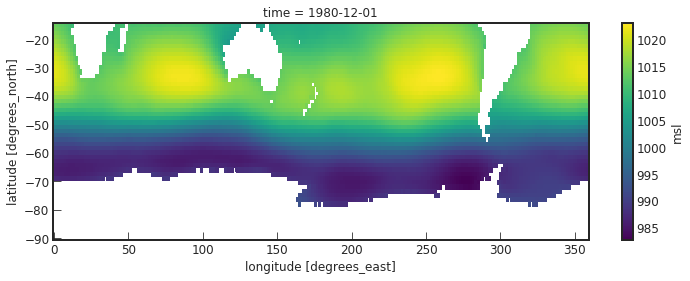

In [37]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_djf(slp_abs_seas_merra['time.month']))
mam_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_mam(slp_abs_seas_merra['time.month']))
jja_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_jja(slp_abs_seas_merra['time.month']))
son_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_son(slp_abs_seas_merra['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
#Do not include the last value (0049) for DJF, as it only contains D
djf_slp_abs_seas_merra[0].plot()
print(djf_slp_abs_seas_merra.time)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_merra_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_merra_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_merra_data], dim='time')
# #djfmean_T2M_tmon_merra_data

<xarray.DataArray 'getitem-2f10d6a4e4195963f59dc1cc6894d6ac' (time: 456, lat: 51, lon: 240)>
dask.array<shape=(456, 51, 240), dtype=float32, chunksize=(456, 51, 240)>
Coordinates:
  * lat      (lat) float64 -15.0 -16.5 -18.0 -19.5 ... -85.5 -87.0 -88.5 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


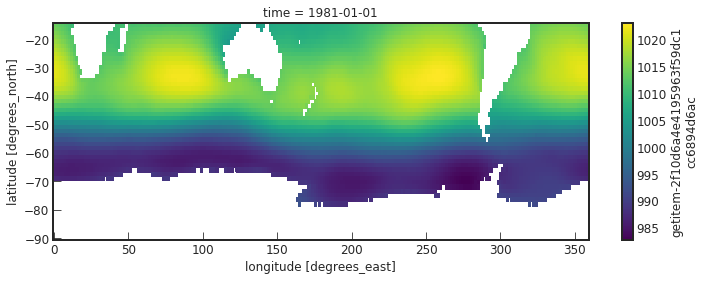

In [38]:
#Field variable with 3,6,12 roll and annual mean
SLP_abs_tmon_merra = SLP_abs_tmon_merra.chunk({'time':468})

slp_abs_roll3_mean_merra = SLP_abs_tmon_merra.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(slp_abs_roll3_mean_merra)
slp_abs_roll3_mean_merra[12].plot()

slp_abs_roll6_mean_merra = SLP_abs_tmon_merra.rolling(time=6, min_periods=6, center=True).mean(axis=0)
#slp_abs_roll6_mean_merra

slp_abs_roll12_mean_merra = SLP_abs_tmon_merra.rolling(time=12, min_periods=12, center=True).mean(axis=0)
#slp_abs_roll12_mean_merra

slp_abs_ann_mean_merra = SLP_abs_tmon_merra.resample(time='AS').mean(axis=0)
# slp_abs_ann_mean_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: Matplotli

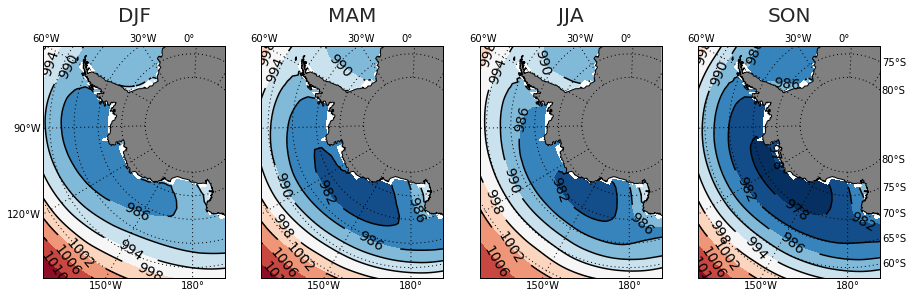

In [39]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].sel(lon=slice(shem_xlo_slice, shem_xhi_slice)).values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values)

levels = np.arange(978,1018,4)

fig = plt.figure(figsize=(15,7))

#DJF
plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

# plt.savefig(FIG_PATH+'/merra_fig1.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

### Hosking et al 2013 definition relative SLP.  I need to subtract off the seasonal mean for each year from the seasonal mean abs CP.

In [40]:
ASL_sectormean_tmon_merra.time

<xarray.DataArray 'time' (time: 456)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', ..., '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
Attributes:
    standard_name:  time
    long_name:      time

In [41]:
#Seasonal Mean
#Seasonal Mean of Sectormean, just an example here to make sure my method below is correct
ASL_sectormean_seas_merra = ASL_sectormean_tmon_merra[2:(len(ASL_sectormean_tmon_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
print(ASL_sectormean_seas_merra[0].values) #MAM for 0002 
print(ASL_sectormean_seas_merra[0])
ASL_sectormean_seas_merra

992.6656125661057
<xarray.DataArray 'msl' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'msl' (time: 151)>
dask.array<shape=(151,), dtype=float64, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1980-03-01 1980-06-01 ... 2017-09-01

In [42]:
#Seasonal Mean continue
djf_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_djf(ASL_sectormean_seas_merra['time.month']))
mam_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_mam(ASL_sectormean_seas_merra['time.month']))
jja_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_jja(ASL_sectormean_seas_merra['time.month']))
son_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_son(ASL_sectormean_seas_merra['time.month']))

print(mam_ASL_sectormean_seas_merra[0].values)
print(mam_ASL_sectormean_seas_merra[0])

#Rolling means and annual mean
ASL_sectormean_tmon_merra = ASL_sectormean_tmon_merra.chunk({'time':468})

ASL_sectormean_roll3_mean_merra = ASL_sectormean_tmon_merra.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(ASL_sectormean_roll3_mean_merra[3].values)
print(ASL_sectormean_roll3_mean_merra[3])

ASL_sectormean_roll6_mean_merra = ASL_sectormean_tmon_merra.rolling(time=6, min_periods=6, center=True).mean(axis=0)

ASL_sectormean_roll12_mean_merra = ASL_sectormean_tmon_merra.rolling(time=12, min_periods=12, center=True).mean(axis=0)

ASL_sectormean_ann_mean_merra = ASL_sectormean_tmon_merra.resample(time='AS').mean(axis=0)



/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


992.6656125661057
<xarray.DataArray 'msl' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01
992.6656125661057
<xarray.DataArray 'getitem-9880b6a0d84fb6d1d3637a97a6103b92' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-04-01


In [43]:
#calculating relative slp in the ASL sector
djf_slp_rel_cp_asl_seas_merra = (djf_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - djf_ASL_sectormean_seas_merra )
mam_slp_rel_cp_asl_seas_merra = (mam_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - mam_ASL_sectormean_seas_merra )
jja_slp_rel_cp_asl_seas_merra = (jja_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - jja_ASL_sectormean_seas_merra )
son_slp_rel_cp_asl_seas_merra = (son_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - son_ASL_sectormean_seas_merra )
roll3_slp_rel_cp_asl_merra = (slp_abs_roll3_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll3_mean_merra )
roll6_slp_rel_cp_asl_merra = (slp_abs_roll6_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll6_mean_merra )
roll12_slp_rel_cp_asl_merra = (slp_abs_roll12_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll12_mean_merra )
ann_mean_slp_rel_cp_asl_merra = (slp_abs_ann_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_ann_mean_merra )


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: Matplotli

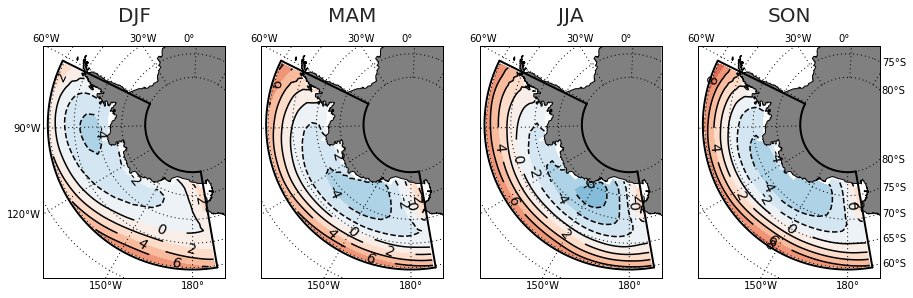

In [44]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].sel(lon=slice(asl_xlo_slice, asl_xhi_slice)).values,MERRA_DATA.coords['lat'].sel(lat=slice(asl_ylo_slice, asl_yhi_slice)).values)

levels = np.arange(-16,18,2)

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

# plt.savefig(FIG_PATH+'/merra_fig2.png',bbox_inches='tight', pad_inches=0.01)



plt.show()

In [45]:
ann_meanish_slp_abs_merra = (djf_slp_abs_seas_merra.mean(dim='time')+mam_slp_abs_seas_merra.mean(dim='time')+jja_slp_abs_seas_merra.mean(dim='time')+son_slp_abs_seas_merra.mean(dim='time'))/4
ann_meanish_slp_rel_cp_merra = (djf_slp_rel_cp_asl_seas_merra.mean(dim='time')+mam_slp_rel_cp_asl_seas_merra.mean(dim='time')+jja_slp_rel_cp_asl_seas_merra.mean(dim='time')+son_slp_rel_cp_asl_seas_merra.mean(dim='time'))/4

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)


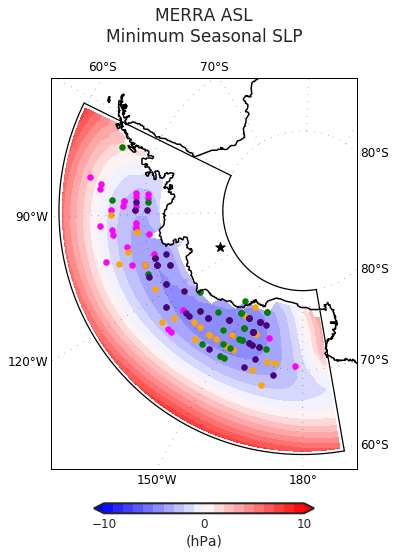

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(27,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0)

# parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
parallels = np.arange(-80,-51,10.)
meridians = np.arange(-180.,31,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#Relative Annual Mean
# plt.subplot(1, 2, 2)
# m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
#             resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].sel(lon=slice(asl_xlo_slice, asl_xhi_slice)).values,MERRA_DATA.coords['lat'].sel(lat=slice(asl_ylo_slice, asl_yhi_slice)).values)

levels = np.arange(-10,11,1)

x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,ann_meanish_slp_rel_cp_merra,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.023, pad=0.08)
cbar.set_label('(hPa)',size=14)
cbar.set_ticks([-10, 0, 10])
cbar.ax.tick_params(labelsize=12)
plt.clim([-10,10])
plt.title('MERRA ASL\nMinimum Seasonal SLP',y=1.08,fontsize=17)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


#DJF CP locations
xpt,ypt = m(Rel_CP_djf_mean_indices_raw_merra.lons.values,
            Rel_CP_djf_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='magenta', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#MAM CP locations
xpt,ypt = m(Rel_CP_mam_mean_indices_raw_merra.lons.values,
            Rel_CP_mam_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='orange', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#JJA CP locations
xpt,ypt = m(Rel_CP_jja_mean_indices_raw_merra.lons.values,
            Rel_CP_jja_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#SON CP locations
xpt,ypt = m(Rel_CP_son_mean_indices_raw_merra.lons.values,
            Rel_CP_son_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='indigo', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'




plt.savefig(FIG_PATH+'/MERRA_BaseMap_No_Topo_No_Ocean_Bounds_29Mar2019.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [47]:
#From Clays tags, Indian goes from 20-145, Pacific from 145-290, and Atlantic from 290-360(I completed this to 20(380))
#I added a 1 degree over lap to eliminate blank space between basins
pac = sst_tmon_merra[0].where((sst_tmon_merra.coords['lon'].values > 145) & (sst_tmon_merra.coords['lon'].values <= 291))
pac_threes = (pac/pac)*3
ind = sst_tmon_merra[0].where((sst_tmon_merra.coords['lon'].values > 20) & (sst_tmon_merra.coords['lon'].values <= 146))
ind_twos = (ind/ind)*2
atl1 = sst_tmon_merra[0].where((sst_tmon_merra.coords['lon'].values > 290) & (sst_tmon_merra.coords['lon'].values <= 360))
atl1_ones = atl1/atl1
atl2 = sst_tmon_merra[0].where((sst_tmon_merra.coords['lon'].values > 0) & (sst_tmon_merra.coords['lon'].values <= 21))
atl2_ones = atl2/atl2

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


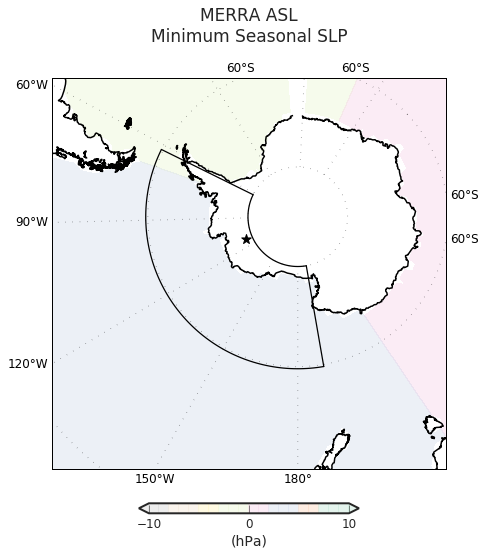

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(27,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0)

# parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
parallels = np.arange(-90,-1,30.)
meridians = np.arange(-180.,31,30.)

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#Relative Annual Mean
# plt.subplot(1, 2, 2)
# m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
#             resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

m = Basemap(llcrnrlon=-135,llcrnrlat=-25,urcrnrlon=45,urcrnrlat=-50,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].values)

levels = np.arange(-10,11,1)

x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,atl1_ones*(-1),levels,cmap=plt.cm.get_cmap('Pastel2_r'),alpha=0.35, extend='both')
CS = m.contourf(x,y,atl2_ones*(-1),levels,cmap=plt.cm.get_cmap('Pastel2_r'),alpha=0.35,extend='both')
CS = m.contourf(x,y,ind_twos,levels,cmap=plt.cm.get_cmap('Pastel2_r'),alpha=0.35,extend='both')
CS = m.contourf(x,y,pac_threes,levels,cmap=plt.cm.get_cmap('Pastel2_r'),alpha=0.35,extend='both')
# cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.023, pad=0.08)
cbar.set_label('(hPa)',size=14)
cbar.set_ticks([-10, 0, 10])
cbar.ax.tick_params(labelsize=12)
plt.clim([-10,10])
plt.title('MERRA ASL\nMinimum Seasonal SLP',y=1.08,fontsize=17)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=1.25)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

# #ADD OCEAN BOUNDARIES (Longitudinal Boundaries)
# lat_line = np.linspace(-80,0,2) 
# lon_line = np.linspace(145,145,2)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=1.25)

# lat_line = np.linspace(-80,0,2) 
# lon_line = np.linspace(20,20,2)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=1.25)

# lat_line = np.linspace(-80,0,2) 
# lon_line = np.linspace(290,290,2)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=1.25)


# #DJF CP locations
# xpt,ypt = m(Rel_CP_djf_mean_indices_raw_merra.lons.values,
#             Rel_CP_djf_mean_indices_raw_merra.lats.values
#            )
# plt.scatter(xpt, ypt, c='magenta', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

# #MAM CP locations
# xpt,ypt = m(Rel_CP_mam_mean_indices_raw_merra.lons.values,
#             Rel_CP_mam_mean_indices_raw_merra.lats.values
#            )
# plt.scatter(xpt, ypt, c='orange', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

# #JJA CP locations
# xpt,ypt = m(Rel_CP_jja_mean_indices_raw_merra.lons.values,
#             Rel_CP_jja_mean_indices_raw_merra.lats.values
#            )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

# #SON CP locations
# xpt,ypt = m(Rel_CP_son_mean_indices_raw_merra.lons.values,
#             Rel_CP_son_mean_indices_raw_merra.lats.values
#            )
# plt.scatter(xpt, ypt, c='indigo', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'




# plt.savefig(FIG_PATH+'/ERA_Interim_BaseMap_for_AGU_Poster_03Dec2018.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## Add topography to the land area

In [49]:
#####Things seem to work better if I do the ERA loading the long way
##Specific to MERRA, ie, not the same chunk and slices as iCESM
# XCHUNK = 240 #Full size chunk seems to make things run quickest
# YCHUNK = 121 #Full Y size chunk makes things run quickest


# ERA4_DATA_PATH = '/glade/work/pgoddard/ERA_Interim_Data/ERA_Interim_Land_Sea_Mask_and_Geopotential_invariant.nc'
MERRA_CONSTANTS_PATH = '/glade/work/pgoddard/MERRA_2/MERRA2_101.const_2d_asm_Nx.00000000.nc4.nc'

In [50]:
#For MERRA, decode_cf needs to be set to True for proper concatenation on T axis

MERRA_CONSTANTS = xr.open_mfdataset(MERRA_CONSTANTS_PATH, decode_cf=True, chunks={'lon':XCHUNK,'lat':YCHUNK})

print(MERRA_CONSTANTS)

<xarray.Dataset>
Dimensions:    (lat: 361, lon: 576, time: 1)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1992-01-02T03:00:00
Data variables:
    FRLAND     (time, lat, lon) float32 dask.array<shape=(1, 361, 576), chunksize=(1, 121, 240)>
    PHIS       (time, lat, lon) float32 dask.array<shape=(1, 361, 576), chunksize=(1, 121, 240)>
    FRLANDICE  (time, lat, lon) float32 dask.array<shape=(1, 361, 576), chunksize=(1, 121, 240)>
    FROCEAN    (time, lat, lon) float32 dask.array<shape=(1, 361, 576), chunksize=(1, 121, 240)>
Attributes:
    History:                           Updated file generated to remove AREA:...
    Comment:                           GMAO filename: d5124_m2_jan79.const_2d...
    Filename:                          MERRA2_101.const_2d_asm_Nx.00000000.nc4
    Conventions:                       CF-1
    Institu

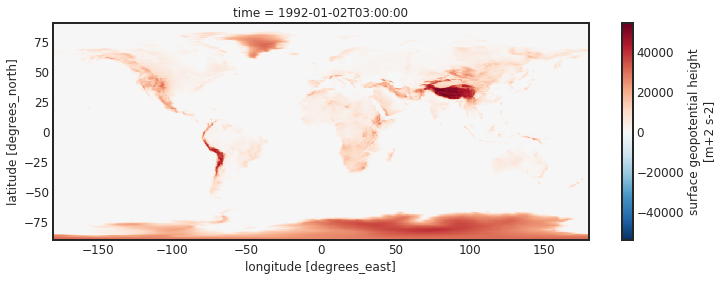

In [51]:
MERRA_CONSTANTS.PHIS.plot()

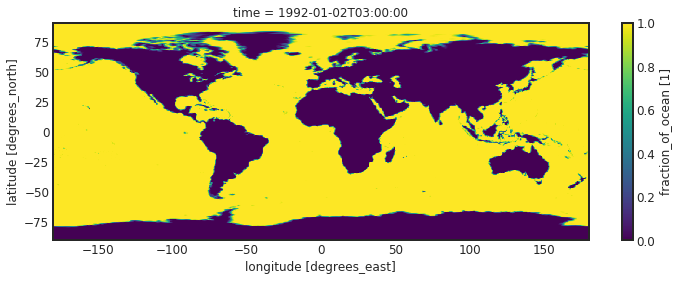

In [52]:
MERRA_CONSTANTS.FROCEAN.plot()

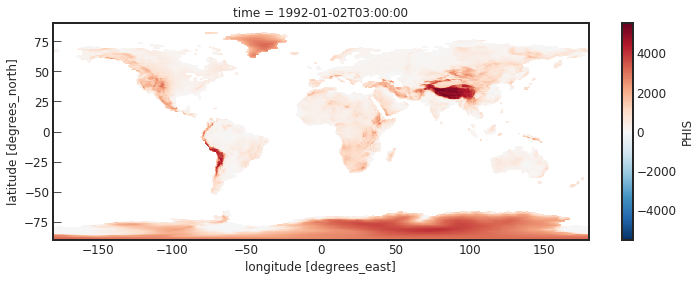

In [53]:
merra_elevation = MERRA_CONSTANTS.PHIS*(1/9.81)  #in m above SL
# merra_elevation.plot()

merra_land_elevation = merra_elevation.where(MERRA_CONSTANTS.FROCEAN.values == 0)
merra_land_elevation.plot()

In [54]:
z_tmon_merra = merra_land_elevation

<xarray.DataArray 'PHIS' (time: 1, lat: 361, lon: 576)>
dask.array<shape=(1, 361, 576), dtype=float32, chunksize=(1, 121, 240)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1992-01-02T03:00:00


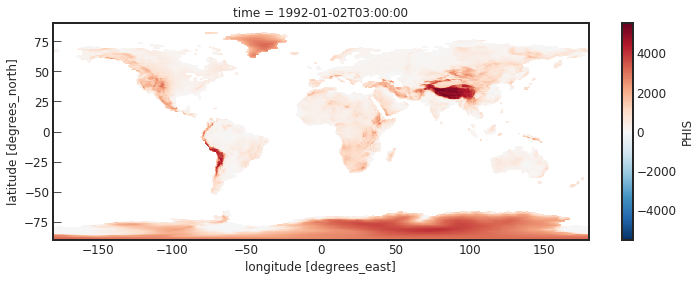

In [55]:
print(z_tmon_merra)
z_tmon_merra.plot()

In [56]:
print(MERRA_CONSTANTS.coords['lon'])
print(MERRA_DATA.coords['lon'])

<xarray.DataArray 'lon' (lon: 576)>
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375])
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    CLASS:         DIMENSION_SCALE
    NAME:          lon
    long_name:     longitude
    units:         degrees_east
    vmax:          1000000000000000.0
    vmin:          -1000000000000000.0
    valid_range:   [-1.e+15  1.e+15]
    origname:      lon
    fullnamepath:  /lon
<xarray.DataArray 'lon' (lon: 240)>
array([  0. ,   1.5,   3. , ..., 355.5, 357. , 358.5])
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


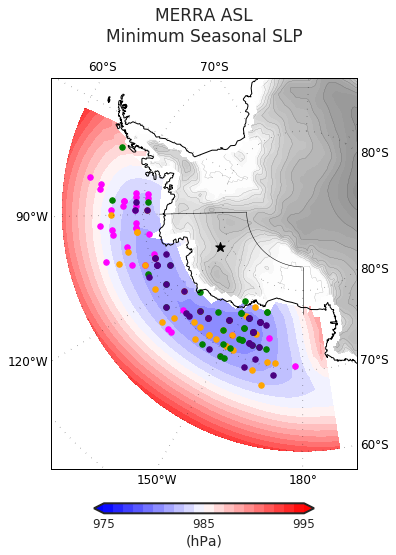

In [57]:
# z_tmon_sliced_merra = z_tmon_merra.sel(lon=slice(shem_xlo_slice, shem_xhi_slice), lat=slice(shem_ylo_slice, shem_yhi_slice))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(27,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0)

# parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
parallels = np.arange(-80,-40,10.)
meridians = np.arange(-180.,180.,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#Relative Annual Mean
# plt.subplot(1, 2, 2)
# m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
#             resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)


lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].sel(lon=slice(asl_xlo_slice, asl_xhi_slice)).values,MERRA_DATA.coords['lat'].sel(lat=slice(asl_ylo_slice, asl_yhi_slice)).values)
lon2, lat2 = np.meshgrid(MERRA_DATA.coords['lon'].sel(lon=slice(shem_xlo_slice, shem_xhi_slice)).values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values)
lon3, lat3 = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].values)
lon4, lat4 = np.meshgrid(MERRA_CONSTANTS.coords['lon'].values,MERRA_CONSTANTS.coords['lat'].values)


levels = np.arange(975,996,1)

x, y = m(lon, lat)
x2, y2 = m(lon2, lat2)
x3, y3 = m(lon3, lat3)
x4, y4 = m(lon4, lat4)

# draw coastlines.
m.drawcoastlines(linewidth=1.)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])

# CS_atl1 = m.contourf(x3,y3,atl1_ones*(-1),levels,cmap=plt.cm.get_cmap('Pastel2'),alpha=0.35,extend='both')
# CS_atl2 = m.contourf(x3,y3,atl2_ones*(-1),levels,cmap=plt.cm.get_cmap('Pastel2'),alpha=0.35,extend='both')
# CS_ind = m.contourf(x3,y3,ind_twos,levels,cmap=plt.cm.get_cmap('Pastel2'),alpha=0.35,extend='both')
# CS_pac = m.contourf(x3,y3,pac_threes,levels,cmap=plt.cm.get_cmap('Pastel2'),alpha=0.35,extend='both')

CS = m.contourf(x,y,ann_meanish_slp_abs_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice),lat=slice(asl_ylo_slice, asl_yhi_slice)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.023, pad=0.08)
cbar.set_label('(hPa)',size=14)
cbar.set_ticks([975, 985, 995])
cbar.ax.tick_params(labelsize=12)
plt.clim([975,995])
CS_topo = m.contourf(x4,y4,z_tmon_merra[0],np.arange(0,9000,200),cmap=plt.cm.get_cmap('binary'))
CS_topo2 = m.contour(x4,y4,z_tmon_merra[0],np.arange(0,9000,400),colors='black',linewidths=0.1)
plt.title('MERRA ASL\nMinimum Seasonal SLP',y=1.08,fontsize=17)

# Add west AA region
lat_line = np.linspace(-83,-83,100) 
lon_line = np.linspace(-180,-90,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=.5) 

# lat_line = np.linspace(-80,-80,100) 
# lon_line = np.linspace(-190,-62,100)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=1.25)

lat_line = np.linspace(-83,-77,2) 
lon_line = np.linspace(-180,-180,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=.5)

lat_line = np.linspace(-83,-72,2) 
lon_line = np.linspace(-90,-90,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=.5)

#Add ASL Box
# lat_line = np.linspace(-59.6,-59.6,100) 
# lon_line = np.linspace(-190,-62,100)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=.5) 

# lat_line = np.linspace(-80,-80,100) 
# lon_line = np.linspace(-190,-62,100)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=.5)

# lat_line = np.linspace(-80,-59.6,2) 
# lon_line = np.linspace(-190,-190,2)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=.5)

# lat_line = np.linspace(-80,-59.6,2) 
# lon_line = np.linspace(-62,-62,2)
# x, y = m(lon_line, lat_line)
# m.plot(x, y, 'k-', linewidth=.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


#DJF CP locations
xpt,ypt = m(Rel_CP_djf_mean_indices_raw_merra.lons.values,
            Rel_CP_djf_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='magenta', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#MAM CP locations
xpt,ypt = m(Rel_CP_mam_mean_indices_raw_merra.lons.values,
            Rel_CP_mam_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='orange', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#JJA CP locations
xpt,ypt = m(Rel_CP_jja_mean_indices_raw_merra.lons.values,
            Rel_CP_jja_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#SON CP locations
xpt,ypt = m(Rel_CP_son_mean_indices_raw_merra.lons.values,
            Rel_CP_son_mean_indices_raw_merra.lats.values
           )
plt.scatter(xpt, ypt, c='indigo', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'




plt.savefig(FIG_PATH+'/Figure_MERRA_BaseMap_Yes_Topo_No_Ocean_Bounds_Yes_West_AA_No_ASL_Lines_and_Mean_SLP_Shaded_29Apr2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()